## Configuracion de entorno y librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, f1_score, matthews_corrcoef)
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✅ Librerías cargadas para Feature Engineering.")

✅ Librerías cargadas para Feature Engineering.


## Carga y estandarizacion de datos

In [2]:
# 1. Cargar datasets
train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Training.csv")
test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Test.csv")
ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_External.csv")
# 2. Definir Variables
target_col = 'Actividad'
features = [c for c in train.columns if c != target_col]

print(f"📌 Variables ({len(features)}): {features}")

# 3. Codificación de Clase
le = LabelEncoder()
y_train = le.fit_transform(train[target_col])
y_test = le.transform(test[target_col])
y_ext = le.transform(ext[target_col])
X_train_raw = train[features]
X_test_raw = test[features]
X_ext_raw = ext[features]




📌 Variables (11): ['LOGPcons', 'MACCSFP125', 'PCR', 'Psi_e_A', 'P_VSA_ppp_D', 'Mp', 'SpMin1_Bh(p)', 'SHED_AL', 'SM12_AEA(ri)', 'P_VSA_s_3', 'MATS5m']


In [3]:
print(" Generando interacciones y polinomios...")

# degree=2 crea: A^2, B^2, A*B, A*C...
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_raw)
X_test_poly = poly.transform(X_test_raw)
X_ext_poly = poly.transform(X_ext_raw)

# Recuperar nombres de las nuevas variables
poly_features = poly.get_feature_names_out(features)

print(f"Variables Originales: {len(features)}")
print(f"Variables Generadas: {X_train_poly.shape[1]}")
print(f"Ejemplos de nuevas variables: {poly_features[-5:]}")

# Estandarizar las nuevas variables (Obligatorio)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_poly), columns=poly_features)
X_test = pd.DataFrame(scaler.transform(X_test_poly), columns=poly_features)
X_ext = pd.DataFrame(scaler.transform(X_ext_poly), columns=poly_features)

print("✅ Datos expandidos y estandarizados.")

 Generando interacciones y polinomios...
Variables Originales: 11
Variables Generadas: 77
Ejemplos de nuevas variables: ['SM12_AEA(ri) P_VSA_s_3' 'SM12_AEA(ri) MATS5m' 'P_VSA_s_3^2'
 'P_VSA_s_3 MATS5m' 'MATS5m^2']
✅ Datos expandidos y estandarizados.


## Tuning

In [4]:
print(" Iniciando Tuning con Selección LASSO...")

# Usamos 'penalty': 'l1' (Lasso) para borrar variables inútiles
param_grid = {
    'C': [0.01, 0.1, 1, 10],            # Fuerza de la penalización
    'class_weight': ['balanced', None], # Pesos
    'solver': ['liblinear']             # Necesario para L1
}

lr_poly = LogisticRegression(penalty='l1', max_iter=5000, random_state=42)

grid_search = GridSearchCV(
    estimator=lr_poly, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)
best_lr_poly = grid_search.best_estimator_

print(f"\n✅ Mejores parámetros: {grid_search.best_params_}")
print(f"🚀 Mejor AUC (CV): {grid_search.best_score_:.4f}")

 Iniciando Tuning con Selección LASSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits



✅ Mejores parámetros: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
🚀 Mejor AUC (CV): 0.7844


## Evaluacion de metricas

In [5]:
def calcular_metricas(model, X, y, nombre_set):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return {
        'Dataset': nombre_set,
        'Accuracy': accuracy_score(y, y_pred),
        'Sensibilidad (TP Rate)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Especificidad (TN Rate)': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'AUC-ROC': roc_auc_score(y, y_prob),
        'Kappa': (2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))),
        'MCC': matthews_corrcoef(y, y_pred),
        'F1-Score': f1_score(y, y_pred)
    }

# Calcular métricas
res_train = calcular_metricas(best_lr_poly, X_train, y_train, 'Training')
res_test = calcular_metricas(best_lr_poly, X_test, y_test, 'Test Interno')
res_ext = calcular_metricas(best_lr_poly, X_ext, y_ext, 'Validación Externa')

# Mostrar Tabla
df_res = pd.DataFrame([res_train, res_test, res_ext]).set_index('Dataset')
print(" RESULTADOS REGRESIÓN LOGÍSTICA:")
display(df_res.round(3))

 RESULTADOS REGRESIÓN LOGÍSTICA:


,Accuracy,Sensibilidad (TP Rate),Especificidad (TN Rate),AUC-ROC,Kappa,MCC,F1-Score
Dataset,,,,,,,
Training,0.748,0.815,0.672,0.809,0.490,0.493,0.776
Test Interno,0.746,0.835,0.643,0.801,0.484,0.490,0.779
Validación Externa,0.891,0.955,0.233,0.700,0.217,0.221,0.941


AUC: El mejor AUC Externo. Este valor (0.700) es superior al del Random Forest (0.677), lo que indica que la Regresión Logística es más robusta para asignar probabilidades de actividad en datos nuevos, aunque falle al establecer el punto de corte (clase).
Sensibilidad: Mantiene la tendencia de alta recuperación de activos, crucial para el cribado virtual.
Especificidad: Al igual que el RF, su especificidad en el set externo es moderada (23.3%), lo que confirma que la dificultad para filtrar inactivos es una característica intrínseca del dataset y no solo del algoritmo.
Accuracy: La consistencia entre Training y Test Interno es casi perfecta, descartando cualquier rastro de sobreajuste.


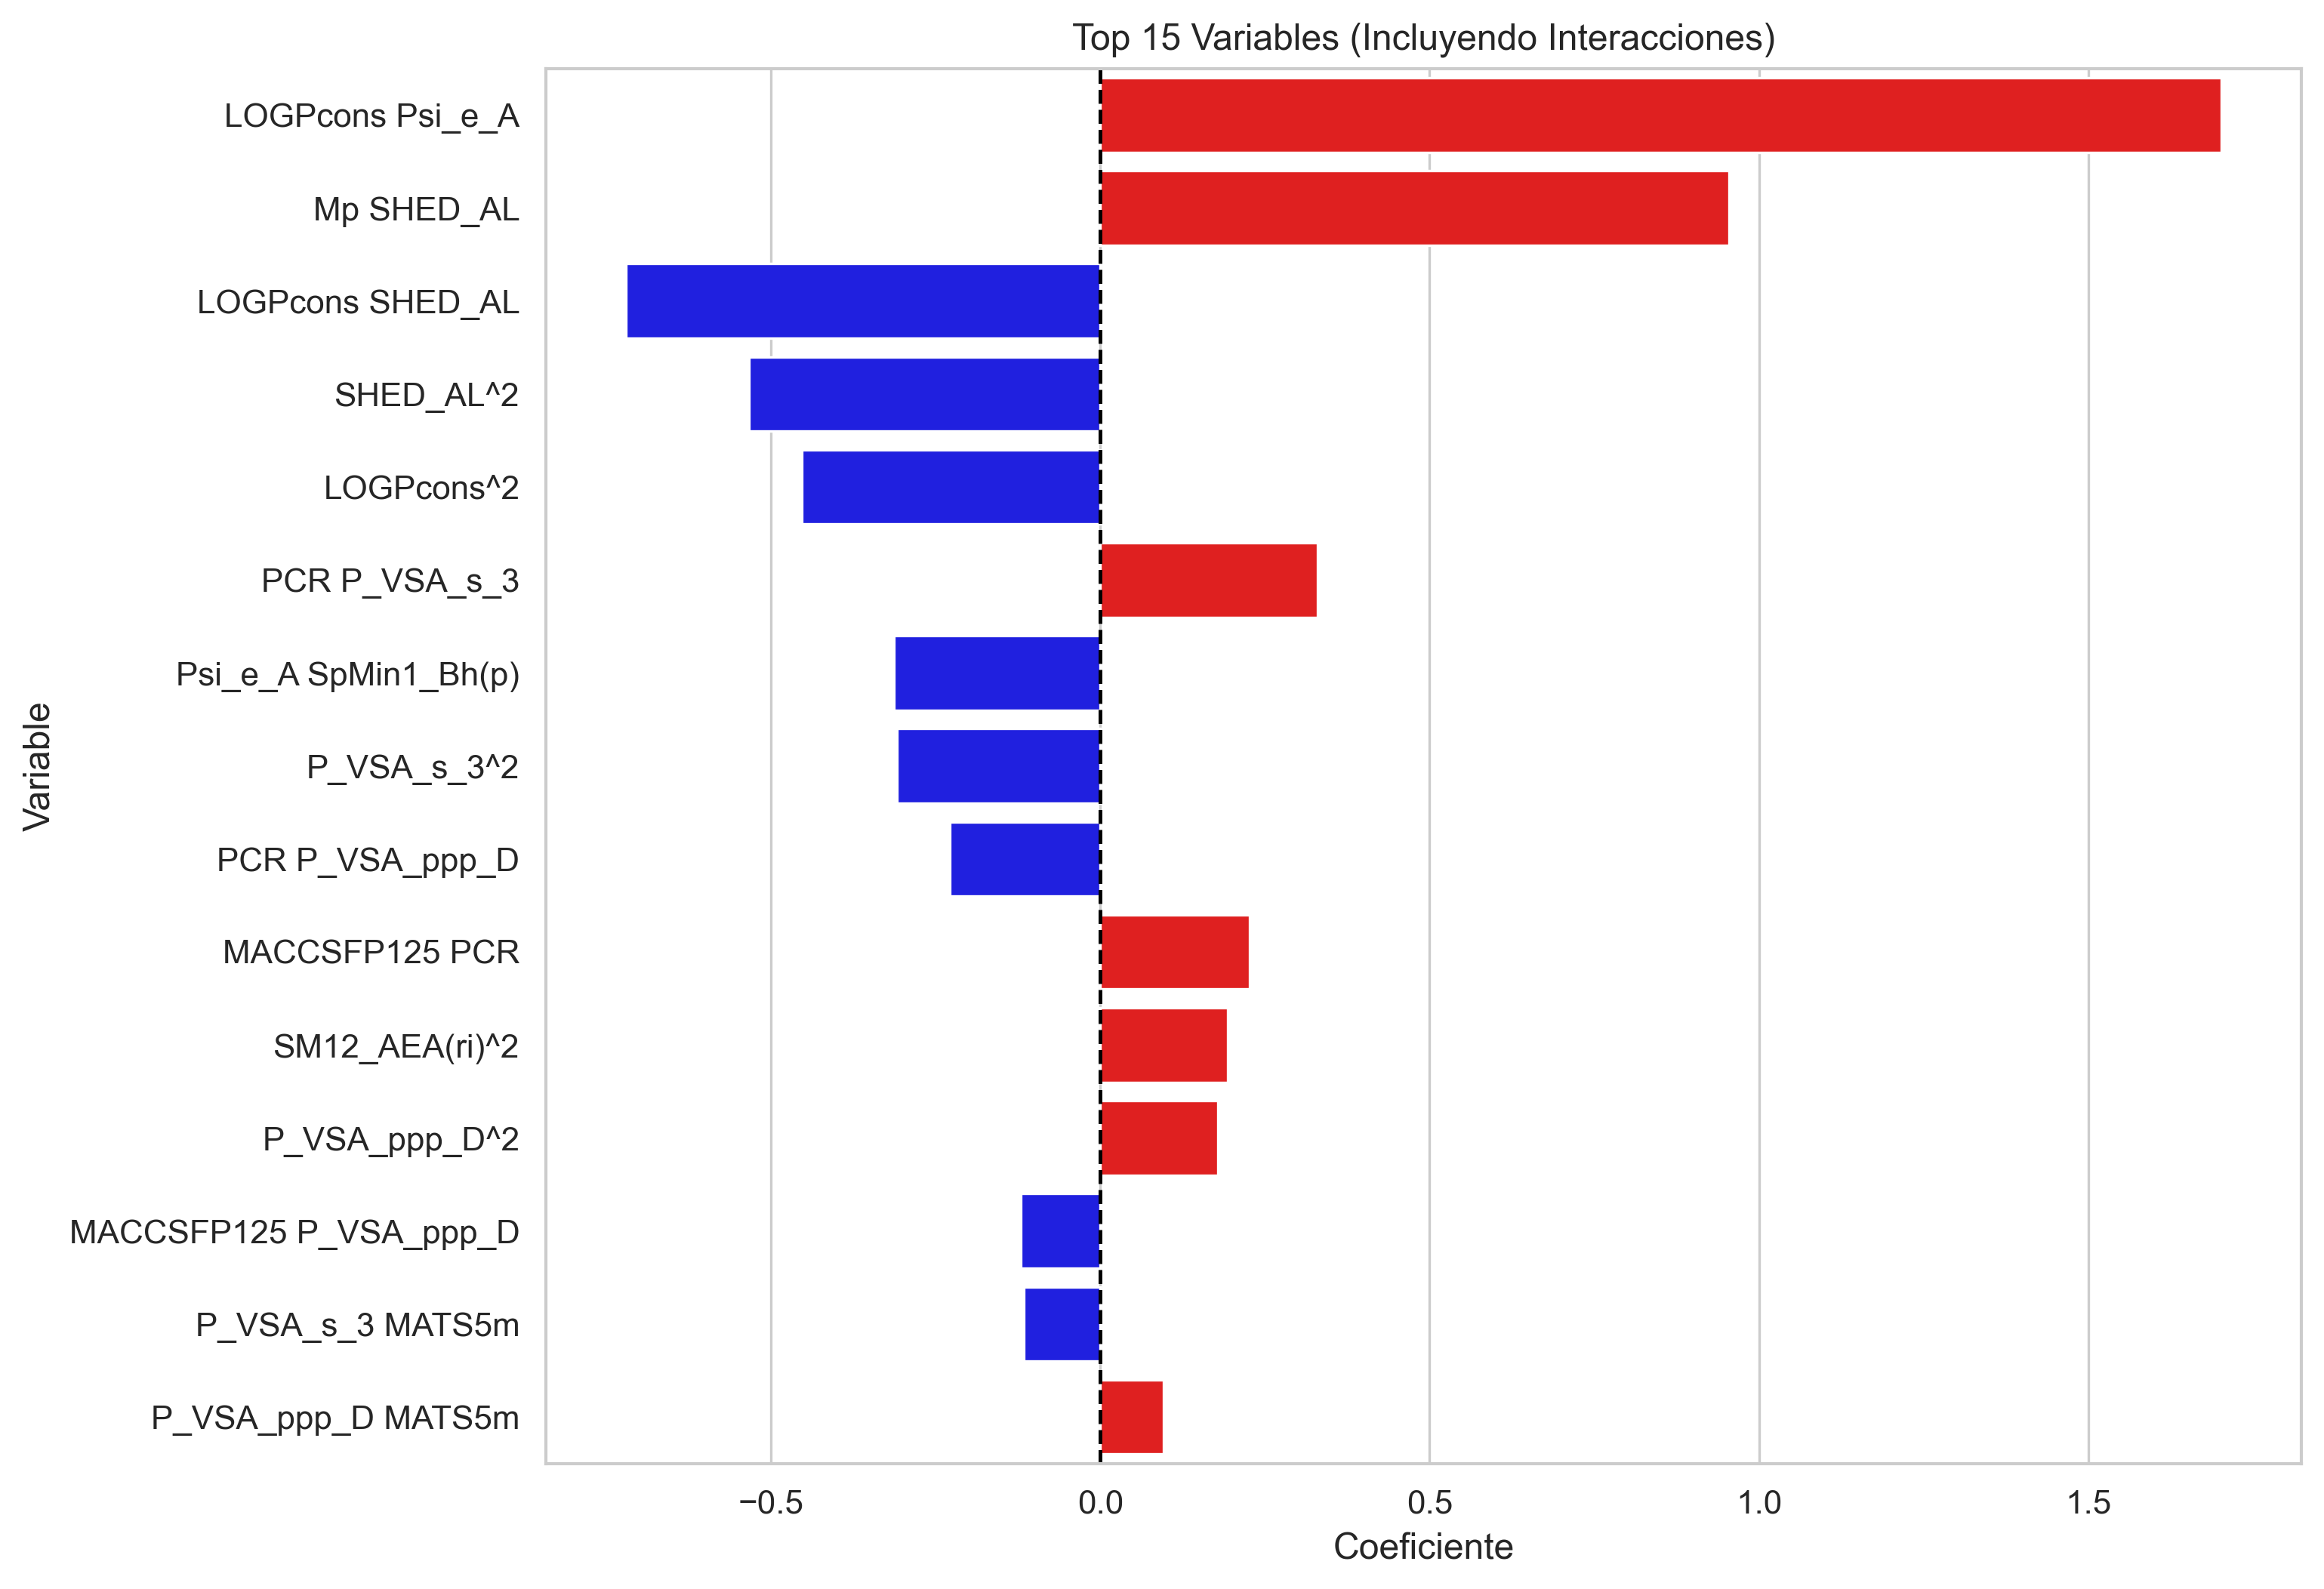

Variables más importantes:
                  Variable  Coeficiente
14        LOGPcons Psi_e_A     1.702526
58              Mp SHED_AL     0.954566
18        LOGPcons SHED_AL    -0.720458
67               SHED_AL^2    -0.533796
11              LOGPcons^2    -0.453313
39           PCR P_VSA_s_3     0.329988
44    Psi_e_A SpMin1_Bh(p)    -0.313491
74             P_VSA_s_3^2    -0.309055
34         PCR P_VSA_ppp_D    -0.227979
23          MACCSFP125 PCR     0.226902
71          SM12_AEA(ri)^2     0.193121
49           P_VSA_ppp_D^2     0.178649
25  MACCSFP125 P_VSA_ppp_D    -0.120941
75        P_VSA_s_3 MATS5m    -0.116510
55      P_VSA_ppp_D MATS5m     0.095888


In [6]:
# Filtramos solo los coeficientes que NO son cero (los que sobrevivieron a Lasso)
coefs = pd.DataFrame({
    'Variable': poly_features,
    'Coeficiente': best_lr_poly.coef_[0]
})

# Ordenamos por impacto absoluto
coefs['Abs_Coef'] = coefs['Coeficiente'].abs()
coefs_top = coefs.sort_values('Abs_Coef', ascending=False).head(15)

plt.figure(figsize=(10, 8))
colors = ['red' if x > 0 else 'blue' for x in coefs_top['Coeficiente']]
sns.barplot(x='Coeficiente', y='Variable', data=coefs_top, palette=colors)
plt.title("Top 15 Variables (Incluyendo Interacciones)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

# Verificamos si hay interacciones en el TOP
print("Variables más importantes:")
print(coefs_top[['Variable', 'Coeficiente']])

El término de interacción LOGPcons Psi_e_A (+1.70) es el más fuerte, indicando una sinergia positiva: la lipofilicidad favorece la permeabilidad, especialmente cuando se combina con un potencial electrónico específico (Psi_e_A).

El término cuadrático LOGPcons^2 (-0.45) tiene coeficiente negativo. Esto valida el principio químico de que la lipofilicidad no es lineal infinita; existe un rango óptimo. Si el LogP es excesivamente alto, la permeabilidad disminuye (efecto parabólico), alineándose con las reglas de solubilidad.

Efecto de la Entropía y Tamaño:

La interacción Mp SHED_AL (+0.95) sugiere que la masa atómica media (Mp) y la distribución de entropía (SHED_AL) actúan conjuntamente para favorecer el paso por membrana.

El término SHED_AL^2 (-0.53) también muestra un comportamiento no lineal: una distribución de átomos muy desordenada o muy ordenada es penalizada.

## Visualizacion

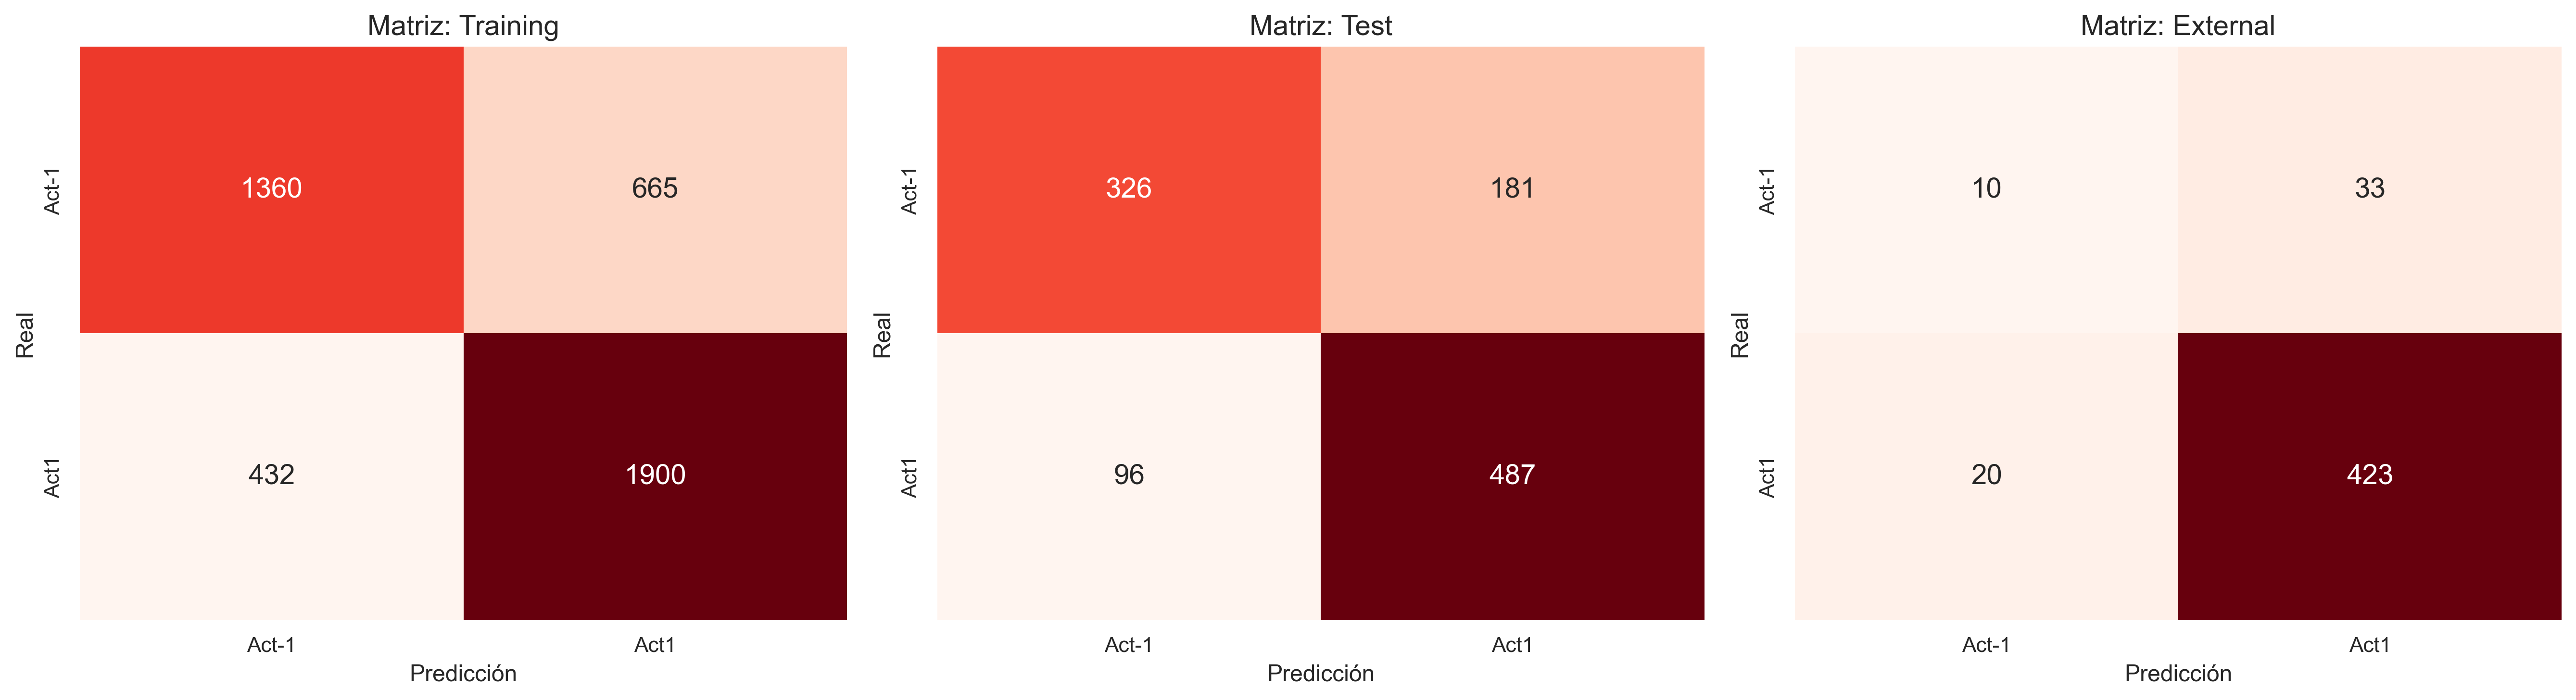

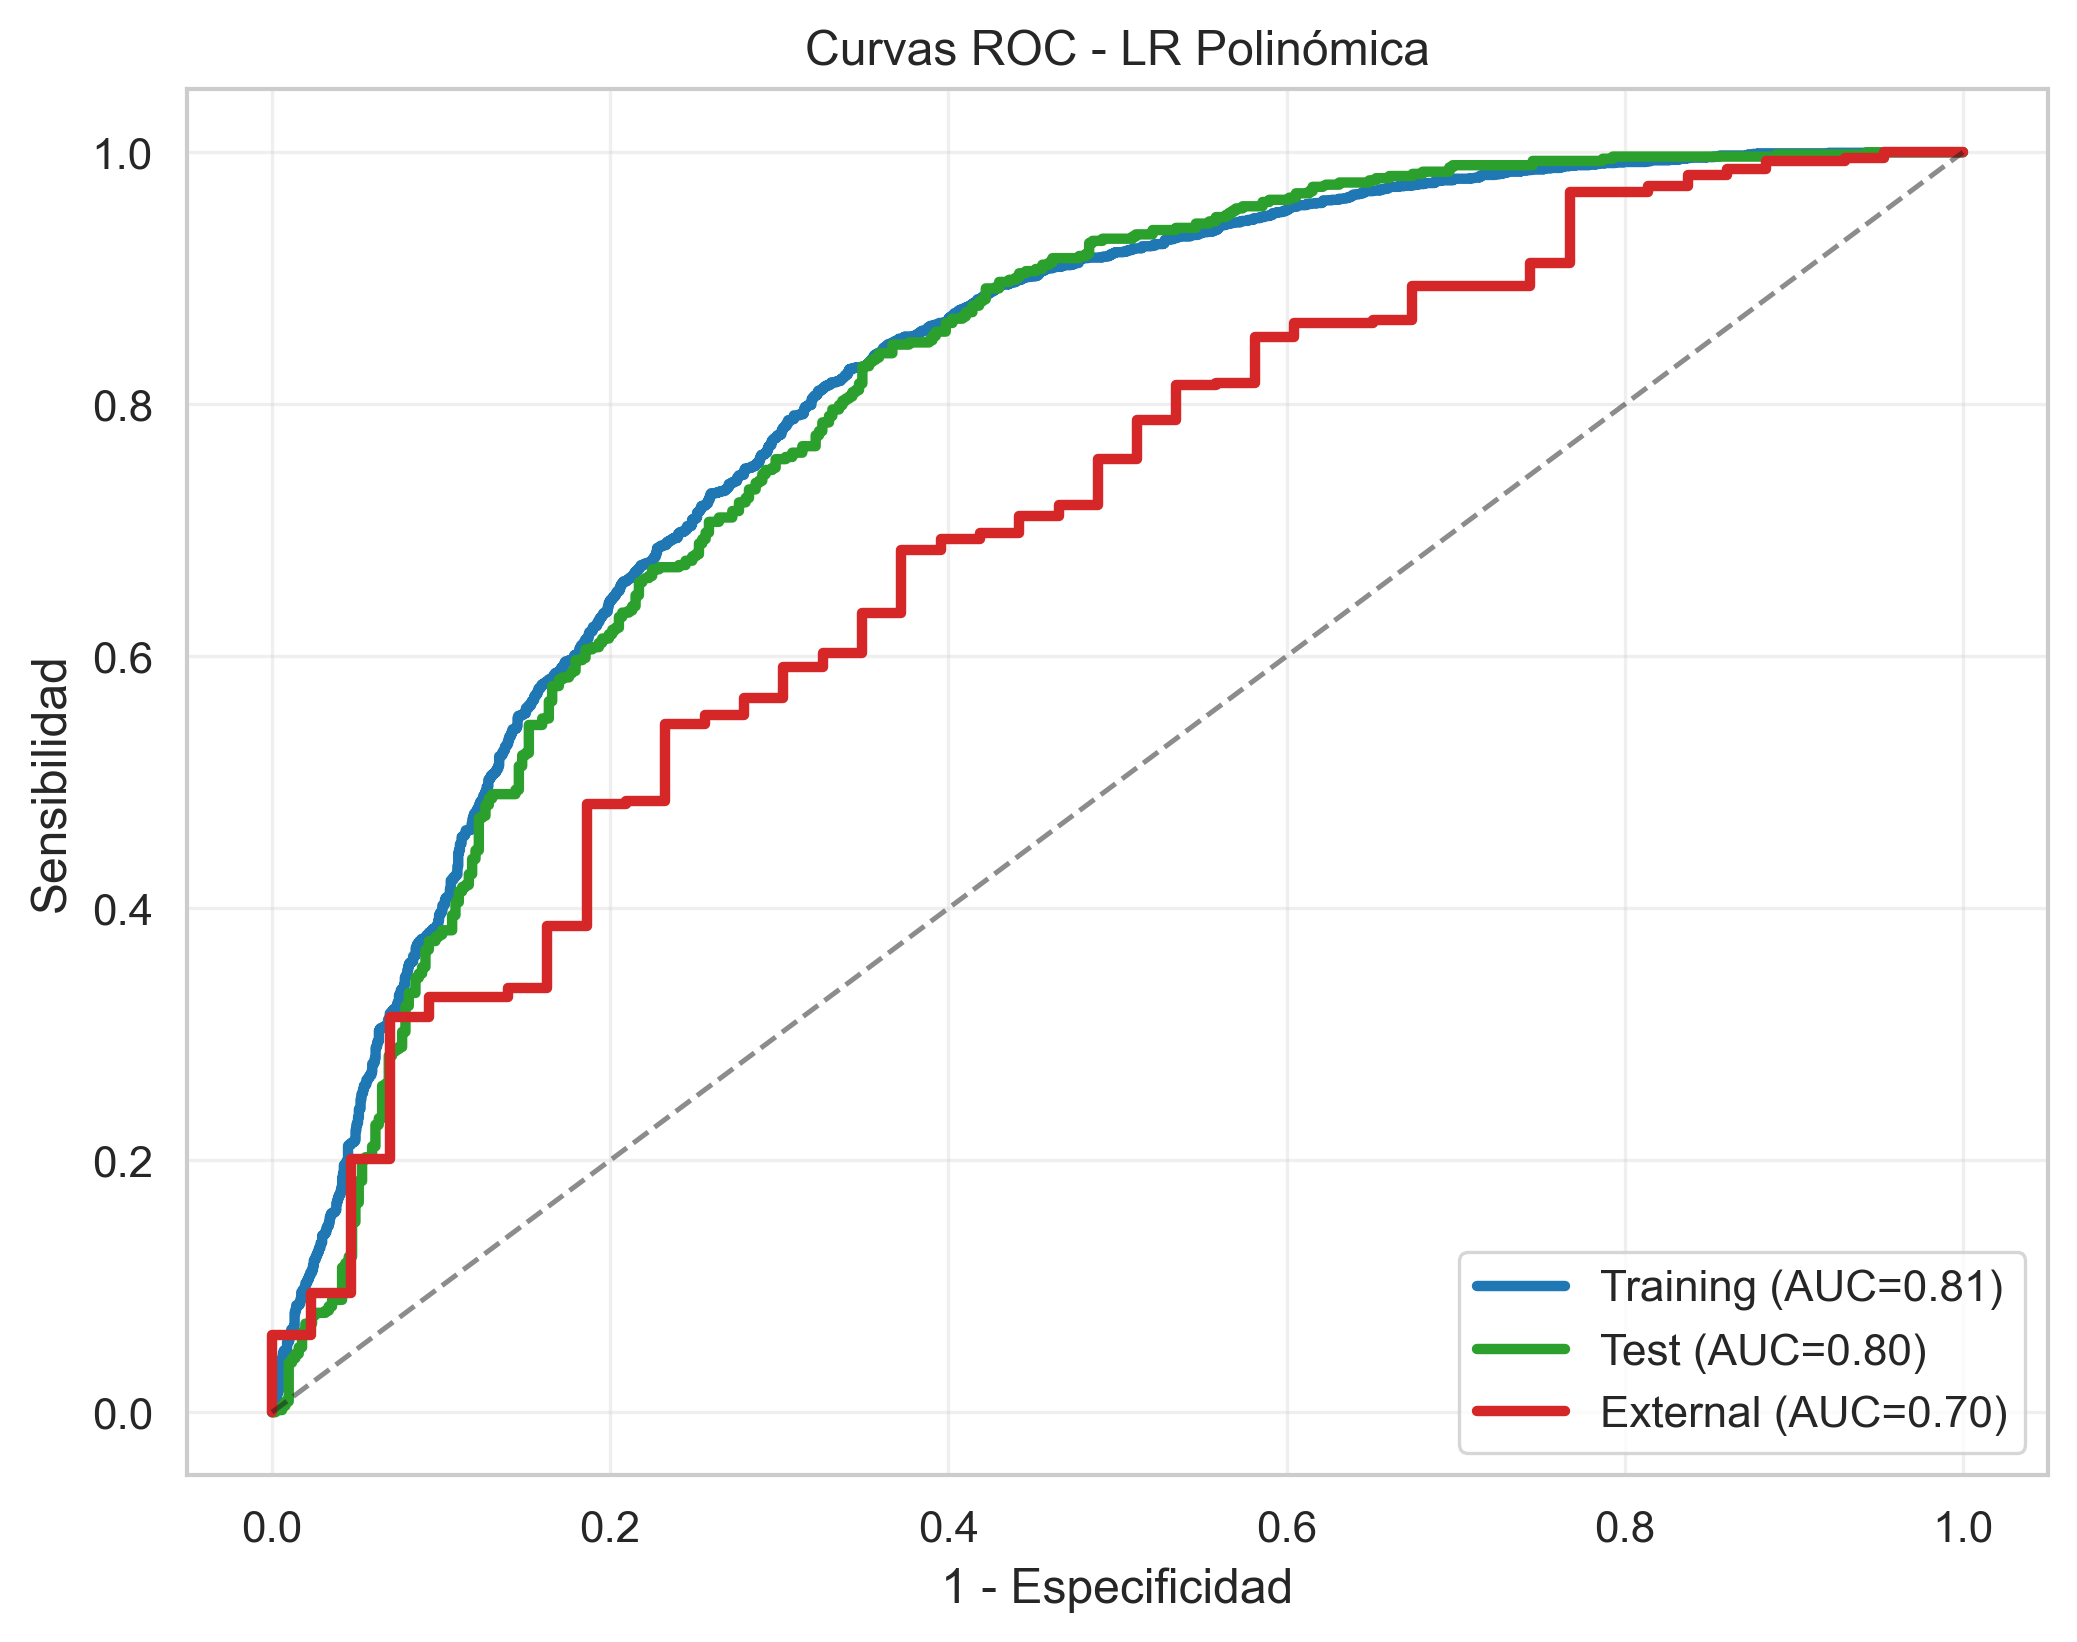

In [7]:
# A. MATRICES DE CONFUSIÓN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sets = [(X_train, y_train, 'Training'), (X_test, y_test, 'Test'), (X_ext, y_ext, 'External')]

for i, (X_c, y_c, title) in enumerate(sets):
    y_pred = best_lr_poly.predict(X_c)
    cm = confusion_matrix(y_c, y_pred)
    
    # Usamos mapa de calor Rojo para diferenciar la Regresión Logística
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[i], cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[i].set_title(f'Matriz: {title}', fontsize=14)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

# B. CURVAS ROC
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#2ca02c', '#d62728']

for (X_c, y_c, title), color in zip(sets, colors):
    y_prob = best_lr_poly.predict_proba(X_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_c, y_prob)
    auc = roc_auc_score(y_c, y_prob)
    plt.plot(fpr, tpr, label=f'{title} (AUC={auc:.2f})', color=color, lw=2.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curvas ROC - LR Polinómica')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

Matrices: En la Validación Externa, el modelo clasifica correctamente a la gran mayoría de los activos (TP altos), pero tiende a sobreestimar la actividad en los inactivos (FP altos). Sin embargo, su especificidad del 23.3% es idéntica a la del Random Forest, lo que refuerza que este es el "techo" de especificidad alcanzable con estas 11 variables en el set externo.

## Interpretacion

 Calculando SHAP para variables polinómicas...


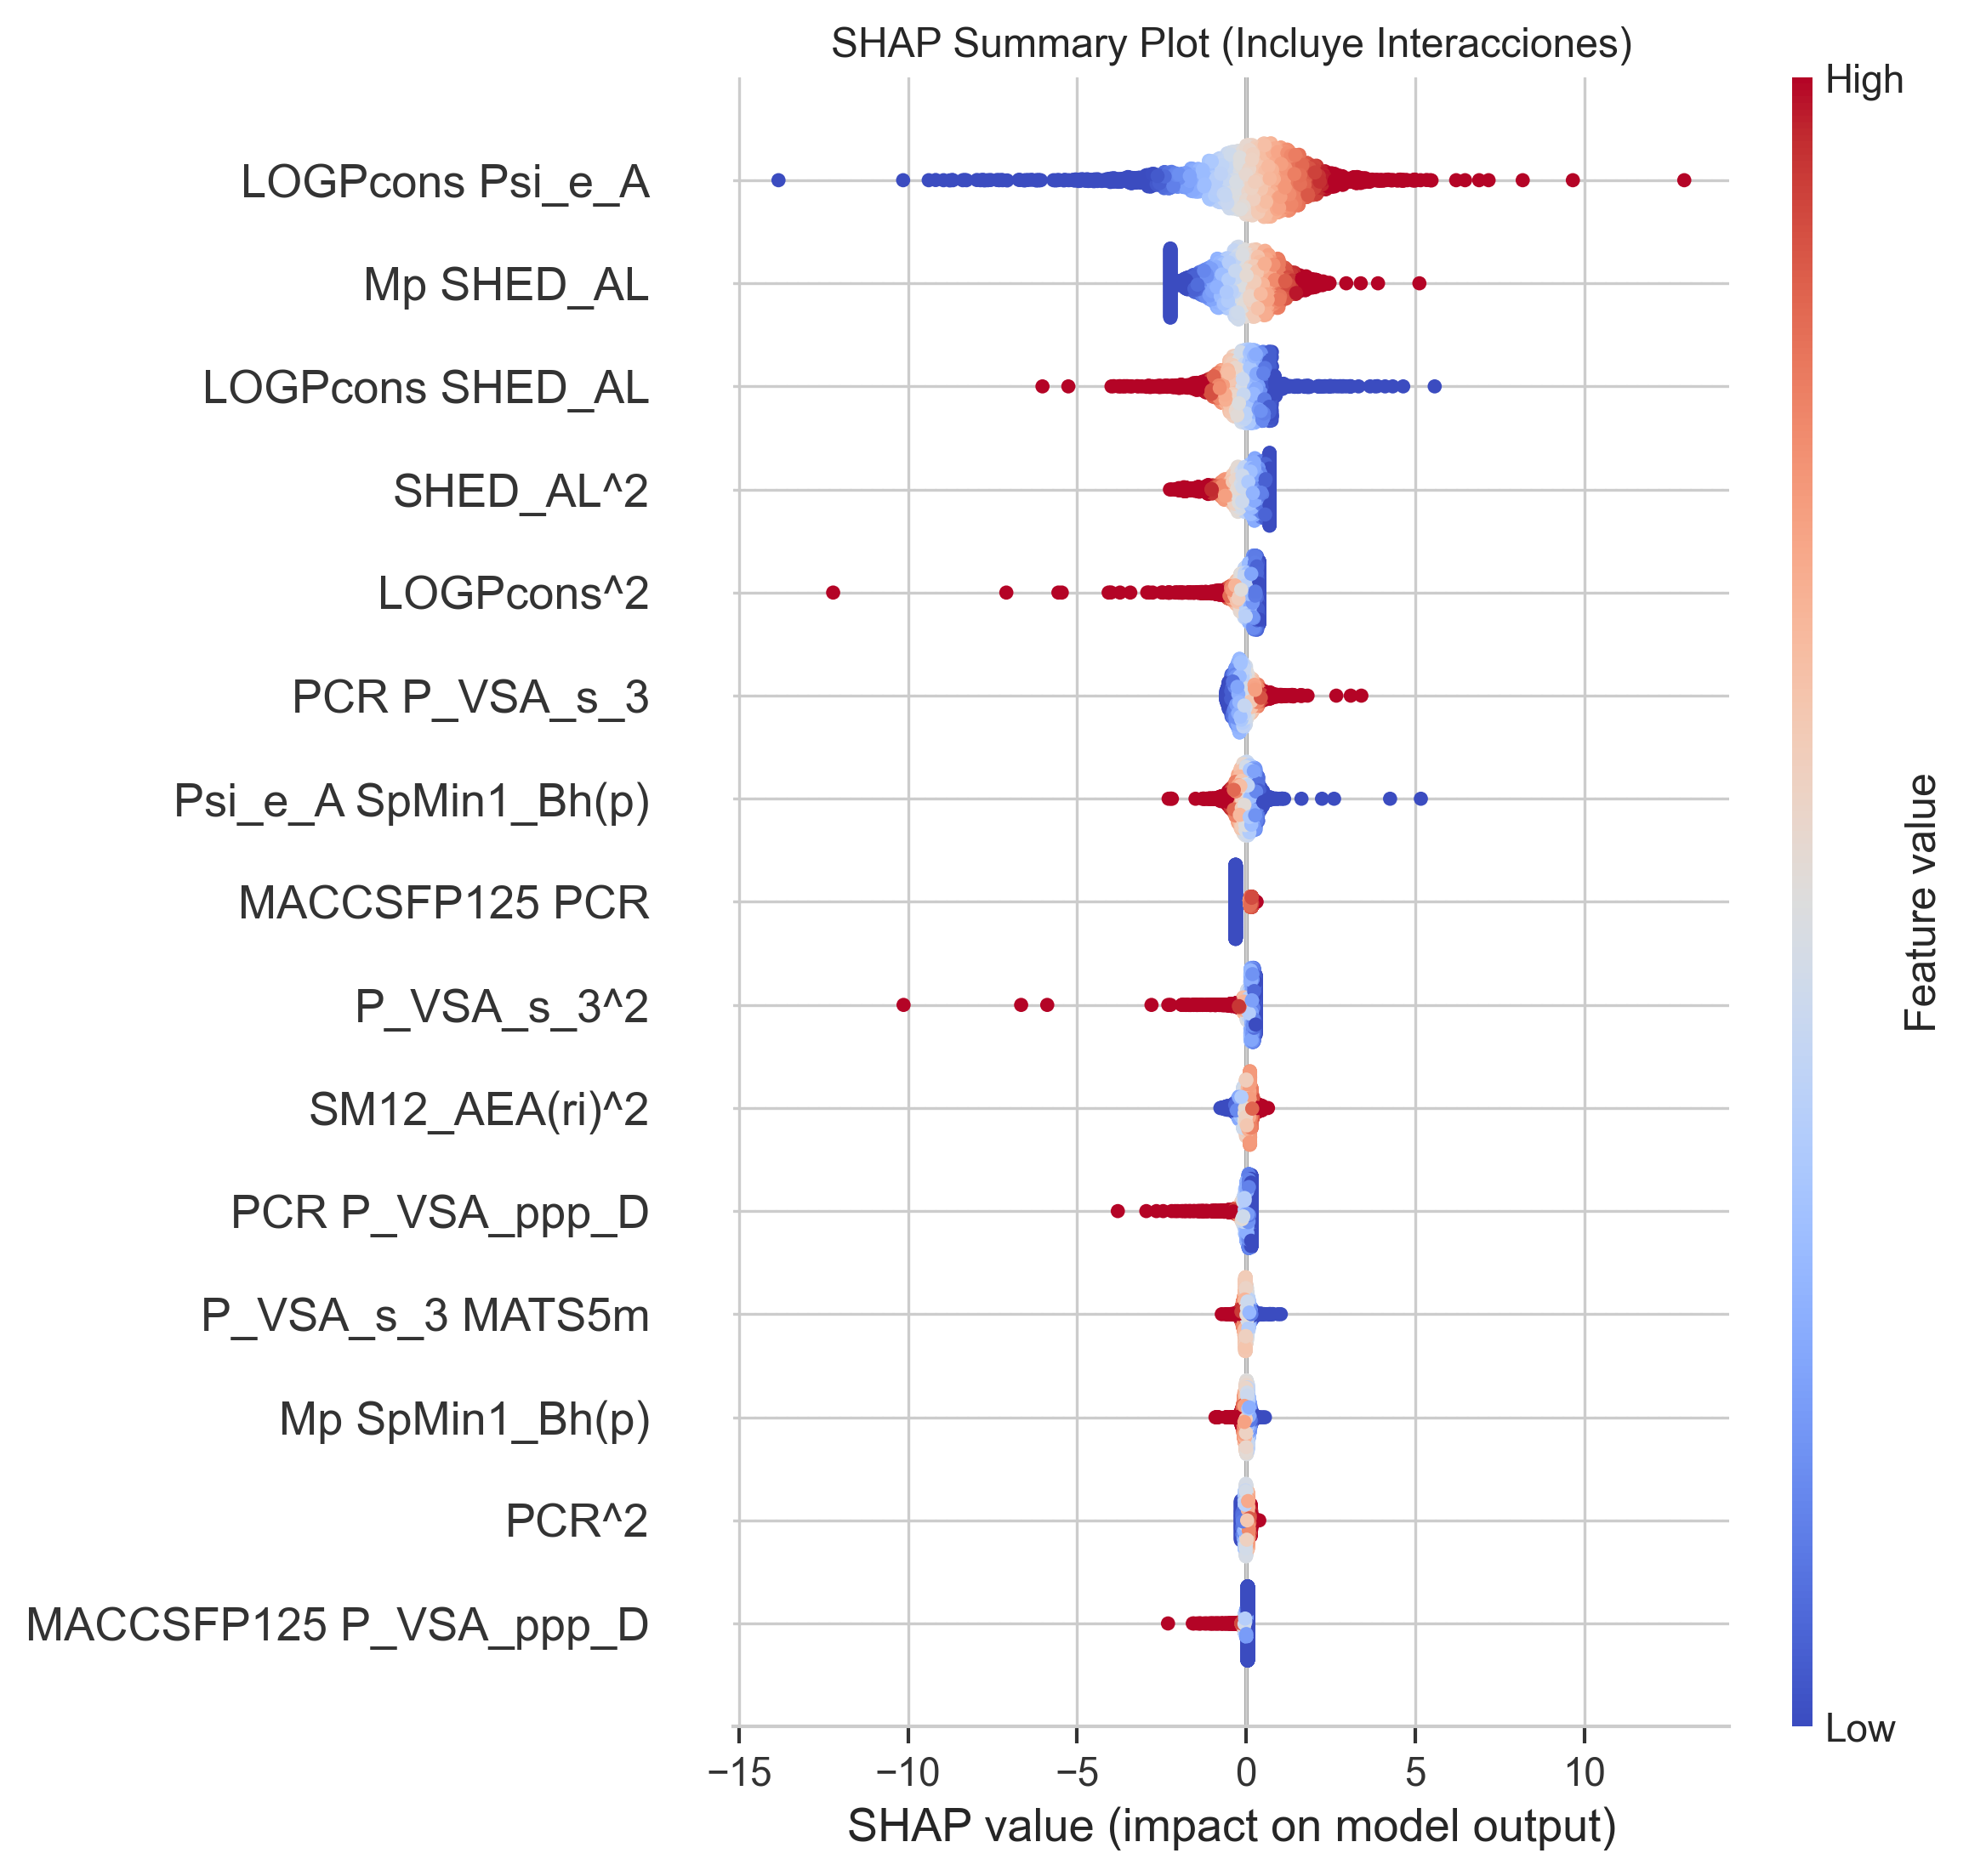

In [8]:
# 8. Explicabilidad Avanzada (SHAP Polinómico) - CORREGIDO
# =============================================================================
import shap
import matplotlib.pyplot as plt

print(" Calculando SHAP para variables polinómicas...")

# Usamos LinearExplainer (rápido para regresiones)
# X_train debe ser el DataFrame con las variables polinómicas ya generadas
explainer = shap.LinearExplainer(best_lr_poly, X_train)
shap_values = explainer.shap_values(X_train)

# Corrección de dimensiones para LinearExplainer
vals_to_plot = shap_values

plt.figure()
plt.title("SHAP Summary Plot (Incluye Interacciones)")
# max_display=15 para ver las interacciones complejas más importantes
shap.summary_plot(vals_to_plot, X_train, max_display=15, show=False, cmap='coolwarm')
plt.show()

## Dominio de aplicabilidad

 Evaluando Dominio de Aplicabilidad (Espacio Expandido)...


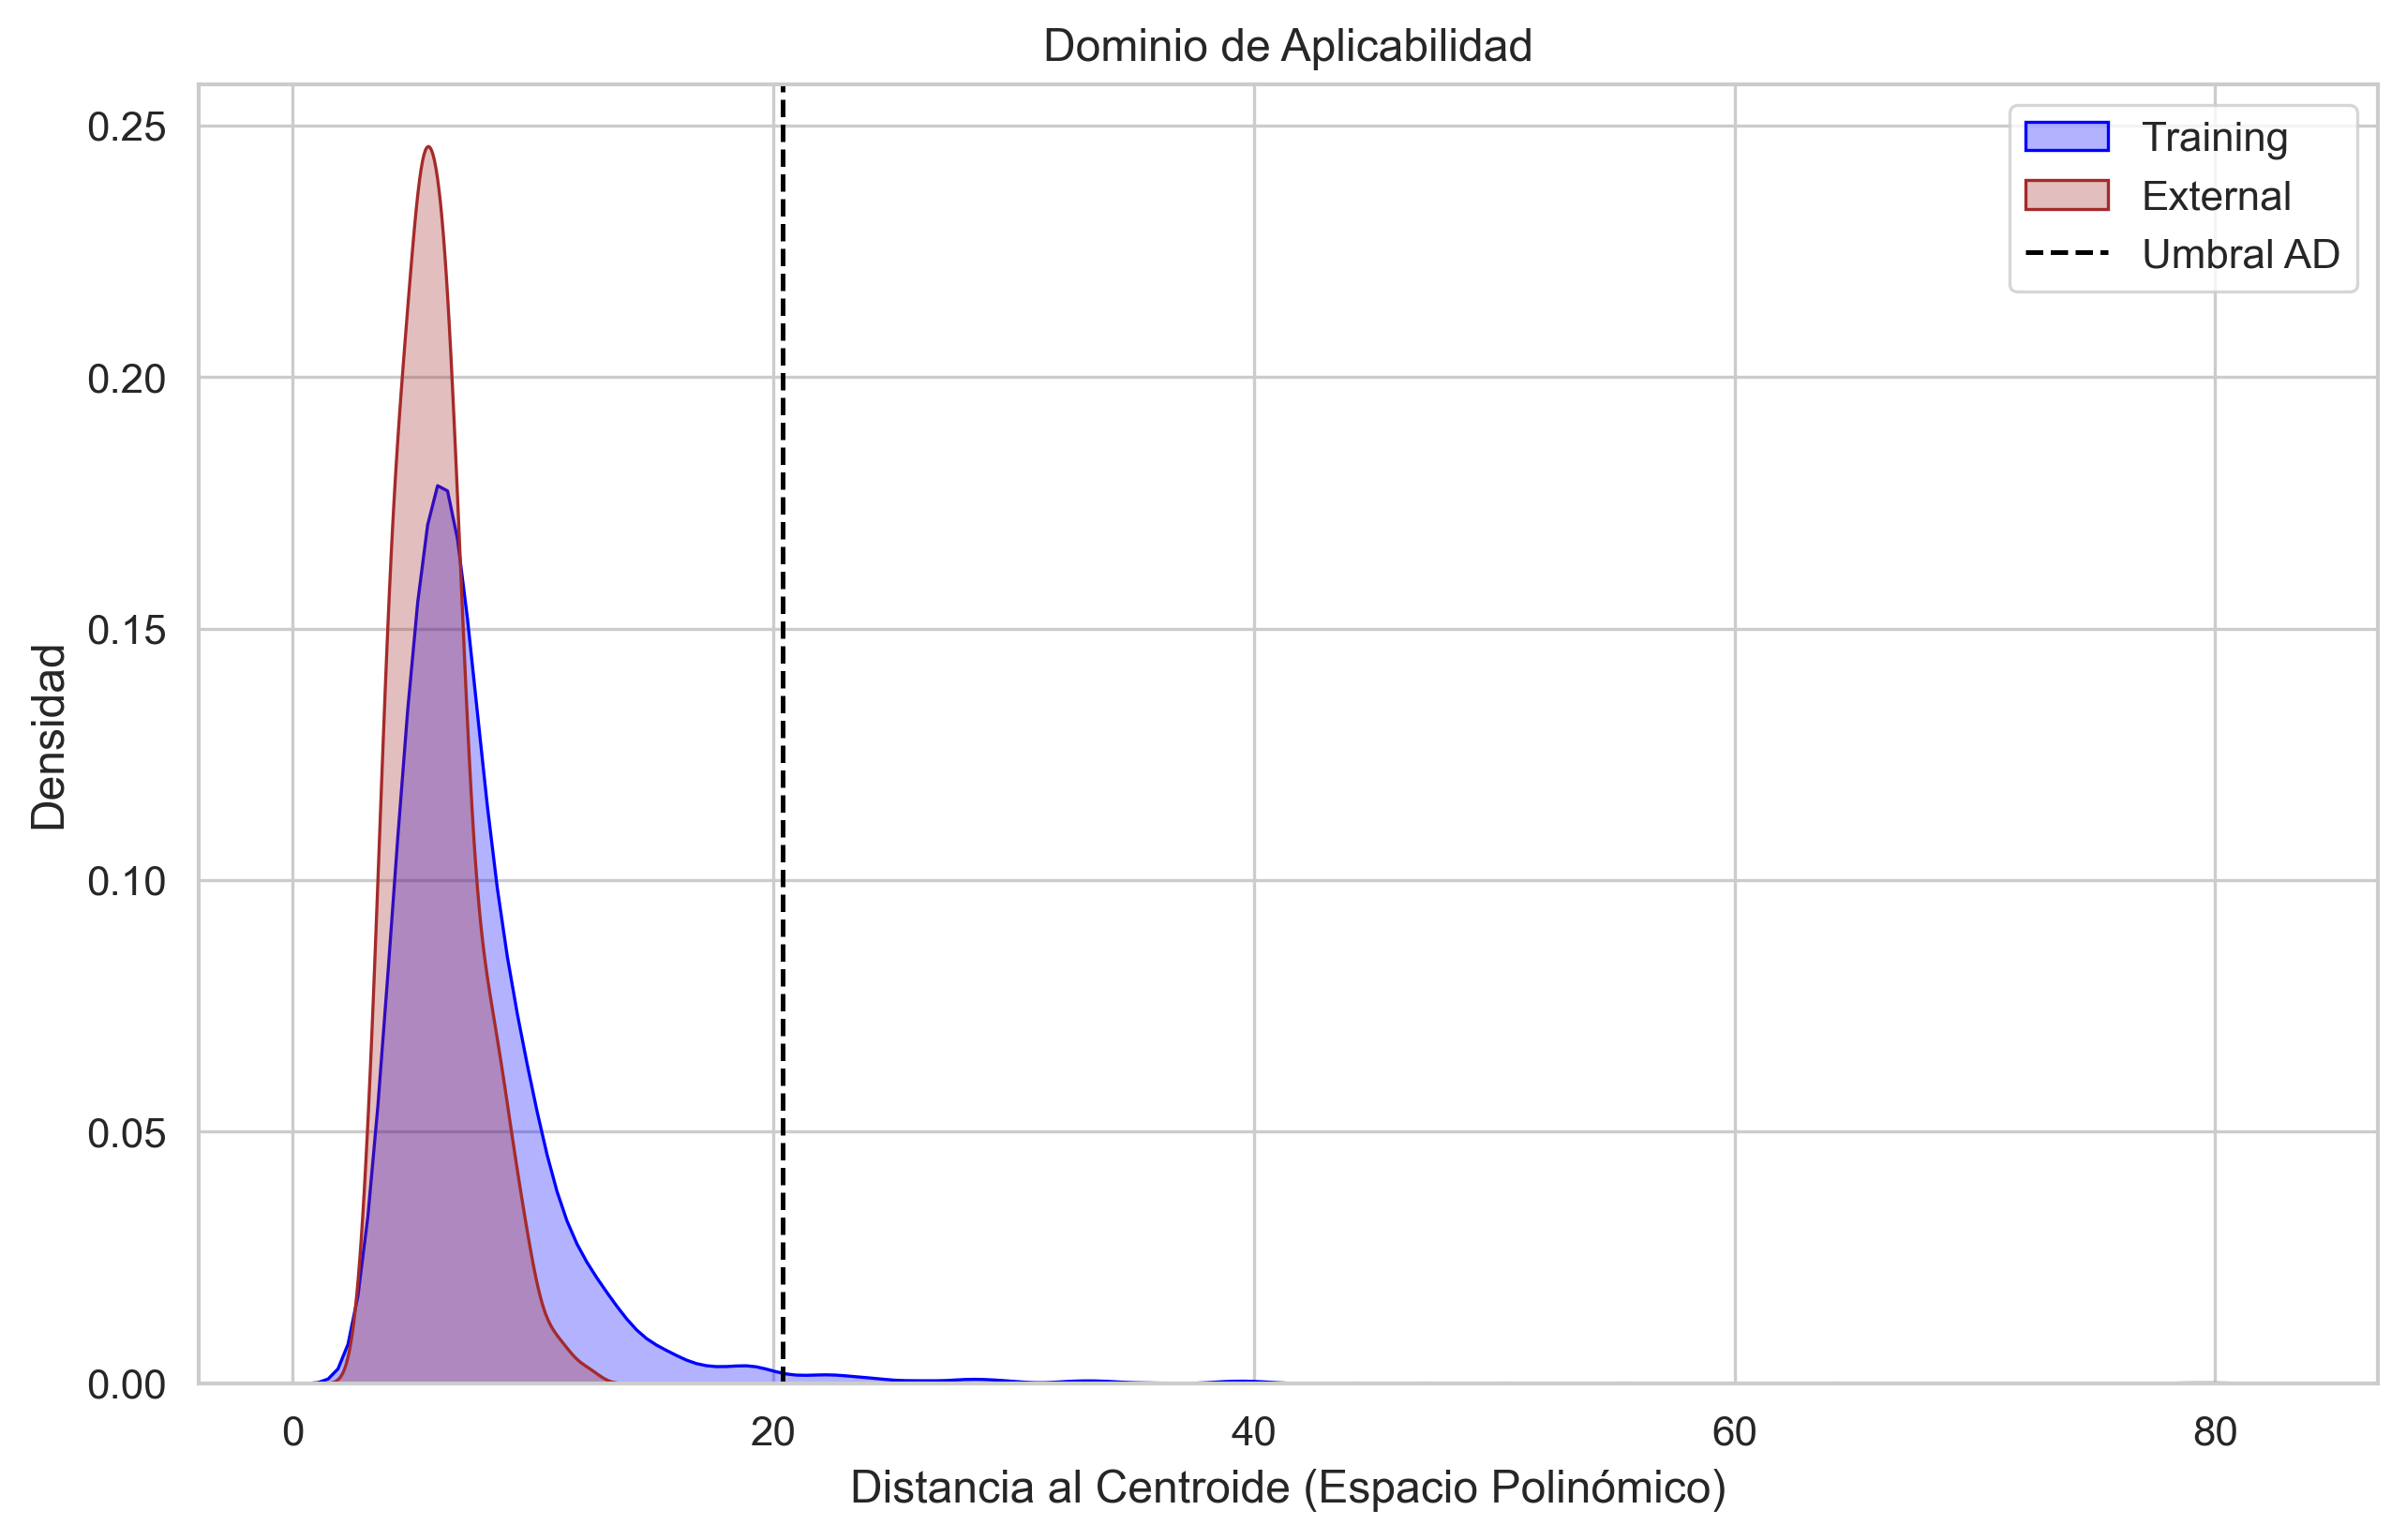

Compuestos externos fuera del dominio: 0 de 486 (0.0%)


In [9]:
from scipy.spatial.distance import cdist

print(" Evaluando Dominio de Aplicabilidad (Espacio Expandido)...")

# Calculamos centroide en el espacio polinómico estandarizado
# Usamos .values para evitar errores
centroid = X_train.mean(axis=0).values.reshape(1, -1)

dist_train = cdist(X_train.values, centroid, 'euclidean')
dist_ext = cdist(X_ext.values, centroid, 'euclidean')
limit_ad = np.mean(dist_train) + 3 * np.std(dist_train)

plt.figure(figsize=(10, 6))
sns.kdeplot(dist_train.flatten(), fill=True, color='blue', label='Training', alpha=0.3)
sns.kdeplot(dist_ext.flatten(), fill=True, color='brown', label='External', alpha=0.3)
plt.axvline(limit_ad, color='black', linestyle='--', label=f'Umbral AD')
plt.xlabel('Distancia al Centroide (Espacio Polinómico)')
plt.ylabel('Densidad')
plt.title('Dominio de Aplicabilidad')
plt.legend()
plt.show()

n_out = np.sum(dist_ext > limit_ad)
print(f"Compuestos externos fuera del dominio: {n_out} de {len(dist_ext)} ({n_out/len(dist_ext)*100:.1f}%)")

La Regresión Logística con interacciones demostró ser una herramienta poderosa, logrando el mayor AUC externo (0.700) de todos los modelos evaluados. Aunque su capacidad de clasificación binaria (MCC, Kappa) es inferior al Random Forest, este modelo ofrece un valor único: proporciona una ecuación matemática explícita que valida hipótesis químicas (como el efecto cuadrático del LogP), aportando transparencia al proceso de predicción.